In [36]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import json
import random
import os
import shutil
import hydra
import logging
import pandas as pd
from tqdm import tqdm

import torch
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# from pytorch_lightning.plugins import DDPPlugin
from avg_ckpts import ensemble
from datamodule.data_module import DataModule
from datamodule.grid_dataset import GridDataset

In [38]:
from datamodule.transforms import VideoTransform

## Testing Dataset/DataLoader

In [ ]:
from datamodule.grid_dataset import GridDataset
root_dir = "/ssd_scratch/cvit/vanshg/preprocessed_grid/video"
label_path = "/ssd_scratch/cvit/vanshg/preprocessed_grid/labels/s1_label.csv"
data_size = 0.8

dataset = GridDataset(root_dir, label_path, VideoTransform("train"), data_size=data_size)

In [12]:
for data in dataset:
    print(type(data))
    print(data['input'].shape)
    print(data['target'])
    break

<class 'dict'>
torch.Size([75, 1, 88, 88])
tensor([ 941,  969,  811, 2033, 4742, 3291])


In [9]:
from datamodule.phrase_dataset import PhraseDataset
from datamodule.data_module_phrase import pad, collate_pad

def _dataloader(ds, collate_fn):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=2,
        num_workers=1,
        # pin_memory=True,
        collate_fn=collate_fn,
    )

root_dir = "/ssd_scratch/cvit/vanshg/datasets/deaf-youtube"
label_path = "/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/cochlear_kaz/all_labels.txt"
data_size = 1.0

dataset = PhraseDataset(root_dir, label_path, VideoTransform('train'), data_size=data_size)

VideoTransform: window = 10 | stride = 25
Label Path : /ssd_scratch/cvit/vanshg/datasets/deaf-youtube/cochlear_kaz/all_labels.txt, exists = True
Size of self.video_list: 1374


In [10]:
for i, data in enumerate(tqdm(dataset)):
    if i > 0:
        break
    print(data.keys()) 
    print(f"{data['video_path'] = }")
    print(f"{data['idx'] = }")
    print(f"{data['idx'].shape = }")
    print(f"{data['input'].shape = }")
    print(f"{data['target'].shape = }")
    print(f"\n")

  0%|          | 0/1374 [00:00<?, ?it/s]

  0%|          | 1/1374 [00:00<02:41,  8.48it/s]

dict_keys(['input', 'target', 'idx', 'video_path'])
data['video_path'] = ['cochlear_kaz/filtered_processed_videos/wywQEg8LqJc_29_159_168.mp4']
data['idx'] = tensor(0)
data['idx'].shape = torch.Size([])
data['input'].shape = torch.Size([50, 1, 88, 88])
data['target'].shape = torch.Size([9])




In [11]:
train_dataloader = _dataloader(dataset, collate_pad)

for i, batch in enumerate(train_dataloader):
    if i > 0:
        break
    print(type(batch))
    print(batch.keys())
    print(f"{batch['ids'] = }")
    print(f"{batch['ids'].shape = }")
    print(f"{batch['targets'].shape = }")
    print(f"{batch['inputs'].shape = }")
    print(f"{batch['input_lengths'] = }")
    print(f"{batch['target_lengths'] = }")
    # print(f"{batch['video_paths'] = }")

ERROR: Unexpected segmentation fault encountered in worker.
 

RuntimeError: DataLoader worker (pid(s) 8544) exited unexpectedly

In [8]:
for data in dataset:
    print(type(data))
    print(data['input'].shape)
    print(data['target'])
    break

<class 'dict'>
torch.Size([1, 53, 88, 88])
tensor([2550, 3231,  544, 2408,  276,  129,  228,  175])


In [9]:
label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/phrases.json"
dst_train_label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/train_phrases_60.json"
dst_test_label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/test_phrases_40.json"

f = open(label_path, 'r')

video_list = json.load(f)
rng = random.Random(69)
rng.shuffle(video_list)

train_video_list = video_list[:60]
test_video_list = video_list[60:]
print(len(train_video_list))
print(len(test_video_list))

with open(dst_train_label_path, 'w') as file:
    json.dump(train_video_list, file)

with open(dst_test_label_path, 'w') as file:
    json.dump(test_video_list, file)

60
40


## Testing inference

In [1]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [1]:
import os
import json
import glob
import csv

import hydra
import cv2
import torch
import torchaudio
import torchvision

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform
from hydra import initialize, compose
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class InferencePipeline(torch.nn.Module):
    def __init__(self, cfg, detector="retinaface"):
        super(InferencePipeline, self).__init__()
        self.modality = cfg.data.modality
        if self.modality in ["audio", "audiovisual"]:
            self.audio_transform = AudioTransform(subset="test")
        if self.modality in ["video", "audiovisual"]:
            if detector == "mediapipe":
                from preparation.detectors.mediapipe.detector import LandmarksDetector
                from preparation.detectors.mediapipe.video_process import VideoProcess
                self.landmarks_detector = LandmarksDetector()
                self.video_process = VideoProcess(convert_gray=False)
            elif detector == "retinaface":
                from preparation.detectors.retinaface.detector import LandmarksDetector
                from preparation.detectors.retinaface.video_process import VideoProcess
                self.landmarks_detector = LandmarksDetector(device="cuda:0")
                self.video_process = VideoProcess(convert_gray=False)
            self.video_transform = VideoTransform(subset="test")

        if cfg.data.modality in ["audio", "video"]:
            from lightning import ModelModule
        elif cfg.data.modality == "audiovisual":
            from lightning_av import ModelModule
        self.modelmodule = ModelModule(cfg)
        self.modelmodule.model.load_state_dict(torch.load(cfg.pretrained_model_path, map_location=lambda storage, loc: storage))
        self.modelmodule.eval()


    def forward(self, data_filename):
        data_filename = os.path.abspath(data_filename)
        assert os.path.isfile(data_filename), f"data_filename: {data_filename} does not exist."

        if self.modality in ["audio", "audiovisual"]:
            audio, sample_rate = self.load_audio(data_filename)
            audio = self.audio_process(audio, sample_rate)
            audio = audio.transpose(1, 0)
            audio = self.audio_transform(audio)

        if self.modality in ["video", "audiovisual"]:
            video = self.load_video(data_filename)
            landmarks = self.landmarks_detector(video)
            video = torch.tensor(self.video_process(video, landmarks)) # (T, H, W, C)
            video = video.permute(0, 3, 1, 2) # (T, C, H, W)
            print(f"video.shape = {video.shape}")
            video = self.video_transform(video)
            print(f"shape of video after transformation: {video.shape}")

            return video
        if self.modality == "video":
            with torch.no_grad():
                self.modelmodule = self.modelmodule.to(device)
                transcript = self.modelmodule(video)
        elif self.modality == "audio":
            with torch.no_grad():
                transcript = self.modelmodule(audio)

        elif self.modality == "audiovisual":
            print(len(audio), len(video))
            assert 530 < len(audio) // len(video) < 670, "The video frame rate should be between 24 and 30 fps."

            rate_ratio = len(audio) // len(video)
            if rate_ratio == 640:
                pass
            else:
                print(f"The ideal video frame rate is set to 25 fps, but the current frame rate ratio, calculated as {len(video)*16000/len(audio):.1f}, which may affect the performance.")
                audio = cut_or_pad(audio, len(video) * 640)
            with torch.no_grad():
                transcript = self.modelmodule(video, audio)

        return transcript

    def load_audio(self, data_filename):
        waveform, sample_rate = torchaudio.load(data_filename, normalize=True)
        return waveform, sample_rate

    def load_video(self, data_filename):
        return torchvision.io.read_video(data_filename, pts_unit="sec")[0].numpy()

    def audio_process(self, waveform, sample_rate, target_sample_rate=16000):
        if sample_rate != target_sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sample_rate, target_sample_rate
            )
        waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

In [8]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")
    cfg.data.modality = 'video'
    cfg.pretrained_model_path = "./checkpoints/lrs3/models/LRS3_V_WER19.1/model.pth"
    cfg.file_path = "/home/vanshg/play/IIITH/research-cvit/lip-reading/Visual_Speech_Recognition_for_Multiple_Languages/data/test/0QVXdEOiCw8/00001.mp4"

    pipeline = InferencePipeline(cfg)
    video = pipeline(cfg.file_path)
    print(f"video.shape after transform = {video.shape}")
    print(f"video.min = {video.min()} | video.max = {video.max()}")
    # video = video.to('cpu')
    # print(video.shape, video.device)

    # with open('processed_video1.pkl', 'wb') as file:
    #     torch.save(video, file)

{'decoder': 0.9, 'ctc': 0.1, 'lm': 0.3, 'length_bonus': 0.0}
init: self.device: cpu
video.shape = torch.Size([49, 96, 96, 3])
shape of video after transformation: torch.Size([1, 49, 88, 88])
video.shape after transform = torch.Size([1, 49, 88, 88])
video.min = -2.1237075328826904 | video.max = 1.7740938663482666


In [9]:
with open('processed_video.pkl', 'rb') as file:
    other_video = torch.load(file)

print(video.shape, video.device, video.dtype)
print(other_video.shape, other_video.device, other_video.dtype)

torch.Size([1, 49, 88, 88]) cpu torch.float32
torch.Size([1, 49, 88, 88]) cpu torch.float32


In [10]:
torch.allclose(video, other_video)

False

In [11]:
with torch.no_grad():
    model = pipeline.modelmodule.to('cuda')
    data = video.to('cuda')
    transcript = model(data)
    print(transcript)

sample.shape = torch.Size([1, 49, 88, 88])
Number of hypothesis: 132
Prediction 0: IT WASN'T REALLY ALL LIKE THIS | scores: {'decoder': -4.883006572723389, 'ctc': -9.339526176452637, 'lm': -27.997802734375}
Prediction 1: IT WASN'T VERY COOL LIKE THIS | scores: {'decoder': -5.048012733459473, 'ctc': -7.849823474884033, 'lm': -29.284236907958984}
Prediction 2: IT WASN'T QUITE ALL LIKE THIS | scores: {'decoder': -6.687277793884277, 'ctc': -11.480616569519043, 'lm': -26.260738372802734}
Prediction 3: IT WASN'T REALLY AT ALL LIKE THIS | scores: {'decoder': -7.503573417663574, 'ctc': -13.569295883178711, 'lm': -25.910791397094727}
Prediction 4: IT WASN'T REALLY QUITE LIKE THIS | scores: {'decoder': -7.709312915802002, 'ctc': -11.921098709106445, 'lm': -26.63516616821289}
Prediction 5: IT WASN'T VERY COOL LOOKING THINGS | scores: {'decoder': -5.334903717041016, 'ctc': -14.818465232849121, 'lm': -35.50229263305664}
Prediction 6: I WASN'T REALLY AT ALL LIKE THIS | scores: {'decoder': -8.1128149

: 

In [6]:
t1 = torch.load('original.pth')
print(t1.shape)

t2 = torch.load('temp.pth')
print(t2.shape)

print(t1)

torch.Size([60, 96, 96, 3])
torch.Size([60, 96, 96, 3])
tensor([[[[118, 103,  94],
          [119, 104,  95],
          [118, 103,  94],
          ...,
          [119,  97,  89],
          [122, 100,  92],
          [124, 102,  94]],

         [[119, 104,  95],
          [119, 104,  95],
          [119, 104,  95],
          ...,
          [120,  98,  90],
          [123, 101,  93],
          [124, 102,  94]],

         [[120, 103,  95],
          [120, 103,  95],
          [119, 102,  94],
          ...,
          [122,  99,  88],
          [125, 102,  91],
          [126, 103,  92]],

         ...,

         [[106, 116, 120],
          [113, 123, 127],
          [100, 108, 115],
          ...,
          [ 79,  55,  49],
          [ 78,  53,  50],
          [ 78,  53,  50]],

         [[115, 123, 128],
          [119, 127, 132],
          [110, 115, 123],
          ...,
          [ 79,  55,  49],
          [ 77,  52,  49],
          [ 77,  52,  49]],

         [[107, 115, 120],
       

In [13]:
not_eq = (t1 != t2)
print(t1.numel())
print(not_eq.sum())

1658880
tensor(1441631)


In [12]:
import nltk
from nltk.corpus import cmudict
from collections import defaultdict

cmu_dict = cmudict.dict()

unique_phonemes = defaultdict(int)

for i, (w, p) in enumerate(cmu_dict.items()):
    phoenemes = p[0]
    for ph in phoenemes:
        if len(ph) == 3:
            unique_phonemes[ph[:2]] += 1
        else:
            unique_phonemes[ph] += 1

print(len(unique_phonemes.keys()))
print(unique_phonemes.keys())

39
dict_keys(['AH', 'EY', 'F', 'AO', 'R', 'T', 'UW', 'W', 'N', 'IH', 'P', 'L', 'AA', 'B', 'ER', 'G', 'K', 'S', 'EH', 'TH', 'M', 'D', 'V', 'Z', 'IY', 'AE', 'OW', 'NG', 'SH', 'HH', 'AW', 'AY', 'JH', 'Y', 'CH', 'ZH', 'UH', 'DH', 'OY'])


'playdate' is not in cmu_dict
1 412


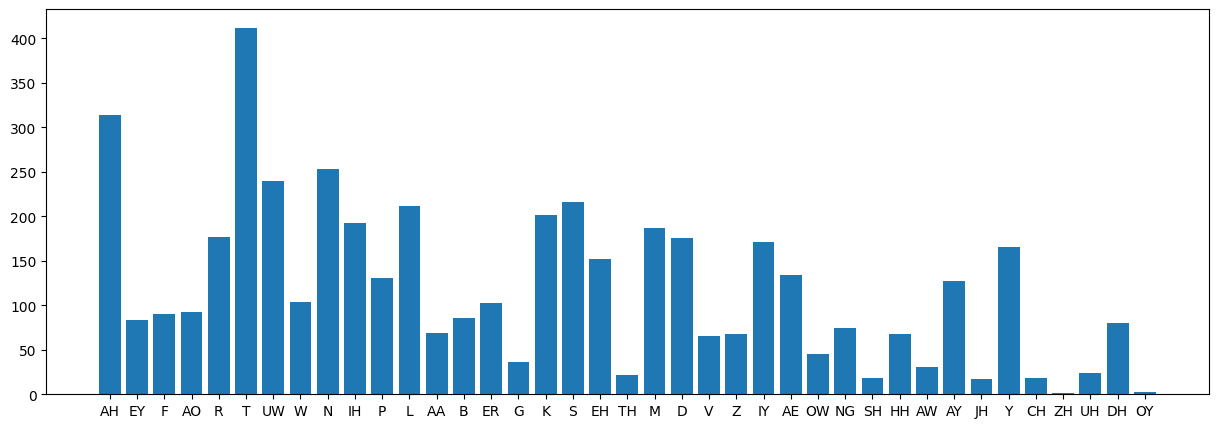

In [37]:
import string
import matplotlib.pyplot as plt

def preprocess_text(text):
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.lower()
    return text

# dictionary for storing the phoneme frequencies
phoeneme_freq = dict()
for ph in unique_phonemes.keys():
    phoeneme_freq[ph] = 0

sentences = open('./vocabs/claude-sentences.txt').readlines()
for sentence in sentences:
    text = preprocess_text(sentence).split()
    for word in text:
        if word in cmu_dict.keys():
            p = cmu_dict[word][0]
            for ph in p:
                if len(ph) == 3:
                    phoeneme_freq[ph[:2]] += 1
                else:
                    phoeneme_freq[ph] += 1
        else:
            print(f"'{word}' is not in cmu_dict")

freq = phoeneme_freq.values()
print(min(freq), max(freq))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(phoeneme_freq.keys(), phoeneme_freq.values())
plt.show()

In [ ]:
import string
import matplotlib.pyplot as plt

def preprocess_text(text):
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.lower()
    return text

# dictionary for storing the phoneme frequencies
phoeneme_freq = dict()
for ph in unique_phonemes.keys():
    phoeneme_freq[ph] = 0

sentences = open('./vocabs/test-sentences-gpt.txt').readlines()
for sentence in sentences:
    text = preprocess_text(sentence).split()
    for word in text:
        if word in cmu_dict.keys():
            p = cmu_dict[word][0]
            for ph in p:
                if len(ph) == 3:
                    phoeneme_freq[ph[:2]] += 1
                else:
                    phoeneme_freq[ph] += 1
        else:
            print(f"'{word}' is not in cmu_dict")

freq = phoeneme_freq.values()
print(min(freq), max(freq))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(phoeneme_freq.keys(), phoeneme_freq.values())
plt.show()

## Testing Preprocessing

In [30]:
import os
import json
import glob
import csv

import cv2
import numpy as np
import hydra
import torch
import torchaudio
import torchvision
import copy
import matplotlib.pyplot as plt

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform


In [31]:
from preparation.detectors.retinaface.detector import LandmarksDetector
from preparation.detectors.retinaface.video_process import VideoProcess

landmarks_detector = LandmarksDetector(device='cuda:0')
video_process = VideoProcess(convert_gray=False)

In [6]:
def load_video(data_filename):
    return torchvision.io.read_video(data_filename, pts_unit="sec")[0].numpy()

In [7]:
vid_filename = "./data/cut-0.mp4"
video = load_video(vid_filename)
print(video.shape)

(768, 360, 640, 3)


In [14]:
landmarks = landmarks_detector(video)

In [35]:
processed_landmarks = video_process.interpolate_landmarks(landmarks)

transformed_frame = video_process.crop_patch(video, processed_landmarks)
print(transformed_frame.shape)

(768, 256, 256, 3)


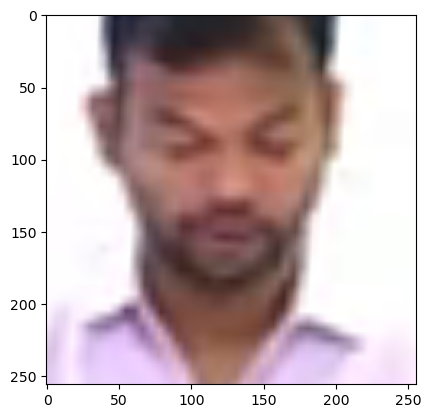

In [41]:
plt.imshow(transformed_frame[400])

## Testing Video frames

In [5]:
import cv2
import matplotlib.pyplot as plt
video_path = '/home/vanshg/play/IIITH/research-cvit/lip-reading/auto_avsr/datasets/Lip2Wav/chem/sentence_clips/--pzKBW13FE/--pzKBW13FE_0_1.mp4'

cap = cv2.VideoCapture(video_path)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

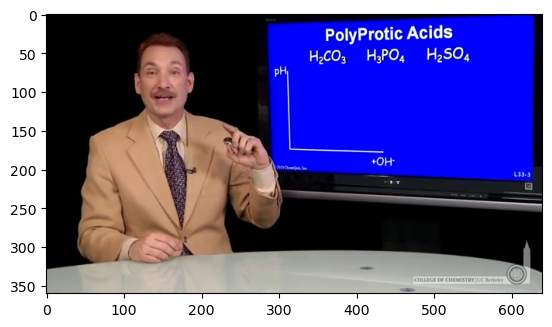

In [13]:
plt.imshow(frames[50])

## Testing Random

In [4]:
import os
import glob

In [17]:
data_dir = "/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset"
speaker_name = "eh"

speaker_dir = os.path.join(data_dir, f"{speaker_name}")
video_dir = os.path.join(speaker_dir, "videos")
video_files = glob.glob(os.path.join(video_dir, f"*.mp4"))
video_ids = [os.path.basename(filepath).split('.')[0] for filepath in video_files]

train_file = os.path.join(speaker_dir, "train.txt")
val_file = os.path.join(speaker_dir, "val.txt")
test_file = os.path.join(speaker_dir, "test.txt")

train_videos = open(train_file).read().split('\n')
val_videos = open(val_file).read().split('\n')
test_videos = open(test_file).read().split('\n')

print(len(train_videos) + len(val_videos) + len(test_videos))

35


## Testing Model Freezing

In [39]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import os
import json
import glob
import csv

import hydra
import cv2
import torch
import torchaudio
import torchvision

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform
from hydra import initialize, compose
from utils.finetune_utils import *
import matplotlib.pyplot as plt
from lightning_phrase import ModelModule

from datamodule.transforms import TextTransform
from espnet.nets.pytorch_backend.e2e_asr_transformer import E2E

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")
    cfg.data.modality = 'video'
    cfg.pretrained_model_path = "./checkpoints/lrs3/models/LRS3_V_WER19.1/model.pth"

print(type(cfg))

<class 'omegaconf.dictconfig.DictConfig'>


In [6]:
text_transform = TextTransform()
token_list = text_transform.token_list
backbone_args = cfg.model.visual_backbone

model = E2E(len(token_list), backbone_args)

In [7]:
total_params = 0
for name, param in model.named_parameters():
    print(f"{name} | {param.shape = } | {param.numel() = }")
    total_params += param.numel()

print(f"Total Number of Parameters in the full model: {total_params}")

encoder.frontend.trunk.layer1.0.conv1.weight | param.shape = torch.Size([64, 64, 3, 3]) | param.numel() = 36864
encoder.frontend.trunk.layer1.0.bn1.weight | param.shape = torch.Size([64]) | param.numel() = 64
encoder.frontend.trunk.layer1.0.bn1.bias | param.shape = torch.Size([64]) | param.numel() = 64
encoder.frontend.trunk.layer1.0.conv2.weight | param.shape = torch.Size([64, 64, 3, 3]) | param.numel() = 36864
encoder.frontend.trunk.layer1.0.bn2.weight | param.shape = torch.Size([64]) | param.numel() = 64
encoder.frontend.trunk.layer1.0.bn2.bias | param.shape = torch.Size([64]) | param.numel() = 64
encoder.frontend.trunk.layer1.1.conv1.weight | param.shape = torch.Size([64, 64, 3, 3]) | param.numel() = 36864
encoder.frontend.trunk.layer1.1.bn1.weight | param.shape = torch.Size([64]) | param.numel() = 64
encoder.frontend.trunk.layer1.1.bn1.bias | param.shape = torch.Size([64]) | param.numel() = 64
encoder.frontend.trunk.layer1.1.conv2.weight | param.shape = torch.Size([64, 64, 3, 3]) 

In [22]:
total_params = 0
for name, param in model.encoder.encoders.named_parameters():
    if 'conv_module' in name:
        print(f"{name} | {param.shape = } | {param.numel() = }")
        total_params += param.numel()

print(f"Total Number of Parameters in model.encoder.encoders all conv_module: {total_params}")

0.conv_module.pointwise_cov1.weight | param.shape = torch.Size([1536, 768, 1]) | param.numel() = 1179648
0.conv_module.pointwise_cov1.bias | param.shape = torch.Size([1536]) | param.numel() = 1536
0.conv_module.depthwise_conv.weight | param.shape = torch.Size([768, 1, 31]) | param.numel() = 23808
0.conv_module.depthwise_conv.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.conv_module.norm.weight | param.shape = torch.Size([768]) | param.numel() = 768
0.conv_module.norm.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.conv_module.pointwise_cov2.weight | param.shape = torch.Size([768, 768, 1]) | param.numel() = 589824
0.conv_module.pointwise_cov2.bias | param.shape = torch.Size([768]) | param.numel() = 768
1.conv_module.pointwise_cov1.weight | param.shape = torch.Size([1536, 768, 1]) | param.numel() = 1179648
1.conv_module.pointwise_cov1.bias | param.shape = torch.Size([1536]) | param.numel() = 1536
1.conv_module.depthwise_conv.weight | param.shape = torch.Si

In [25]:
total_params = 0
for name, param in model.encoder.encoders.named_parameters():
    if 'feed_forward.' in name:
        print(f"{name} | {param.shape = } | {param.numel() = }")
        total_params += param.numel()

print(f"Total Number of Parameters in model.encoder.encoders all feed_forward: {total_params}")

0.feed_forward.w_1.weight | param.shape = torch.Size([3072, 768]) | param.numel() = 2359296
0.feed_forward.w_1.bias | param.shape = torch.Size([3072]) | param.numel() = 3072
0.feed_forward.w_2.weight | param.shape = torch.Size([768, 3072]) | param.numel() = 2359296
0.feed_forward.w_2.bias | param.shape = torch.Size([768]) | param.numel() = 768
1.feed_forward.w_1.weight | param.shape = torch.Size([3072, 768]) | param.numel() = 2359296
1.feed_forward.w_1.bias | param.shape = torch.Size([3072]) | param.numel() = 3072
1.feed_forward.w_2.weight | param.shape = torch.Size([768, 3072]) | param.numel() = 2359296
1.feed_forward.w_2.bias | param.shape = torch.Size([768]) | param.numel() = 768
2.feed_forward.w_1.weight | param.shape = torch.Size([3072, 768]) | param.numel() = 2359296
2.feed_forward.w_1.bias | param.shape = torch.Size([3072]) | param.numel() = 3072
2.feed_forward.w_2.weight | param.shape = torch.Size([768, 3072]) | param.numel() = 2359296
2.feed_forward.w_2.bias | param.shape = to

In [23]:
total_params = 0
for name, param in model.encoder.encoders.named_parameters():
    if 'self_attn' in name:
        print(f"{name} | {param.shape = } | {param.numel() = }")
        total_params += param.numel()

print(f"Total Number of Parameters in model.encoder.encoders all self_attn: {total_params}")

0.self_attn.pos_bias_u | param.shape = torch.Size([12, 64]) | param.numel() = 768
0.self_attn.pos_bias_v | param.shape = torch.Size([12, 64]) | param.numel() = 768
0.self_attn.linear_q.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_q.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_k.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_k.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_v.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_v.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_out.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_out.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_pos.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
1.self_attn.pos_bias_u | param.shape = tor

In [8]:
total_params = 0
for name, param in model.encoder.encoders.named_parameters():
    print(f"{name} | {param.shape = } | {param.numel() = }")
    total_params += param.numel()

print(f"Total Number of Parameters in model.encoder.encoders: {total_params}")

0.self_attn.pos_bias_u | param.shape = torch.Size([12, 64]) | param.numel() = 768
0.self_attn.pos_bias_v | param.shape = torch.Size([12, 64]) | param.numel() = 768
0.self_attn.linear_q.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_q.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_k.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_k.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_v.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_v.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_out.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.self_attn.linear_out.bias | param.shape = torch.Size([768]) | param.numel() = 768
0.self_attn.linear_pos.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
0.feed_forward.w_1.weight | param.shape = 

In [17]:
num_blocks = len(model.encoder.encoders)
total_params = 0
for i in range(num_blocks // 2):
    for (name, param) in model.encoder.encoders[i].named_parameters():
        print(f"{name} | {param.shape = } | {param.numel() = }")
        total_params += param.numel()
        # param.requires_grad_(True)

print(f"Total Number of parameters in Encoder Top Half: {total_params}")

self_attn.pos_bias_u | param.shape = torch.Size([12, 64]) | param.numel() = 768
self_attn.pos_bias_v | param.shape = torch.Size([12, 64]) | param.numel() = 768
self_attn.linear_q.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
self_attn.linear_q.bias | param.shape = torch.Size([768]) | param.numel() = 768
self_attn.linear_k.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
self_attn.linear_k.bias | param.shape = torch.Size([768]) | param.numel() = 768
self_attn.linear_v.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
self_attn.linear_v.bias | param.shape = torch.Size([768]) | param.numel() = 768
self_attn.linear_out.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
self_attn.linear_out.bias | param.shape = torch.Size([768]) | param.numel() = 768
self_attn.linear_pos.weight | param.shape = torch.Size([768, 768]) | param.numel() = 589824
feed_forward.w_1.weight | param.shape = torch.Size([3072, 768]) 

In [23]:
print(model.ctc)

CTC(
  (ctc_lo): Linear(in_features=768, out_features=5049, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (ctc_loss): CTCLoss()
)


In [48]:
freeze_decoder(model)
freeze_ctc(model)
for (name, param) in model.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

encoder.frontend.trunk.layer1.0.conv1.weight True
encoder.frontend.trunk.layer1.0.bn1.weight True
encoder.frontend.trunk.layer1.0.bn1.bias True
encoder.frontend.trunk.layer1.0.conv2.weight True
encoder.frontend.trunk.layer1.0.bn2.weight True
encoder.frontend.trunk.layer1.0.bn2.bias True
encoder.frontend.trunk.layer1.1.conv1.weight True
encoder.frontend.trunk.layer1.1.bn1.weight True
encoder.frontend.trunk.layer1.1.bn1.bias True
encoder.frontend.trunk.layer1.1.conv2.weight True
encoder.frontend.trunk.layer1.1.bn2.weight True
encoder.frontend.trunk.layer1.1.bn2.bias True
encoder.frontend.trunk.layer2.0.conv1.weight True
encoder.frontend.trunk.layer2.0.bn1.weight True
encoder.frontend.trunk.layer2.0.bn1.bias True
encoder.frontend.trunk.layer2.0.conv2.weight True
encoder.frontend.trunk.layer2.0.bn2.weight True
encoder.frontend.trunk.layer2.0.bn2.bias True
encoder.frontend.trunk.layer2.0.downsample.0.weight True
encoder.frontend.trunk.layer2.0.downsample.1.weight True
encoder.frontend.trunk

In [35]:
# from utils.finetune_utils import finetune_encoders_feed_forward
finetune_encoders_feed_forward(model)
for (name, param) in model.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

encoder.encoders.0.feed_forward.w_1.weight True
encoder.encoders.0.feed_forward.w_1.bias True
encoder.encoders.0.feed_forward.w_2.weight True
encoder.encoders.0.feed_forward.w_2.bias True
encoder.encoders.0.feed_forward_macaron.w_1.weight True
encoder.encoders.0.feed_forward_macaron.w_1.bias True
encoder.encoders.0.feed_forward_macaron.w_2.weight True
encoder.encoders.0.feed_forward_macaron.w_2.bias True
encoder.encoders.1.feed_forward.w_1.weight True
encoder.encoders.1.feed_forward.w_1.bias True
encoder.encoders.1.feed_forward.w_2.weight True
encoder.encoders.1.feed_forward.w_2.bias True
encoder.encoders.1.feed_forward_macaron.w_1.weight True
encoder.encoders.1.feed_forward_macaron.w_1.bias True
encoder.encoders.1.feed_forward_macaron.w_2.weight True
encoder.encoders.1.feed_forward_macaron.w_2.bias True
encoder.encoders.2.feed_forward.w_1.weight True
encoder.encoders.2.feed_forward.w_1.bias True
encoder.encoders.2.feed_forward.w_2.weight True
encoder.encoders.2.feed_forward.w_2.bias T

## Testing Weight Differences

In [41]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os
import json
import glob
import csv

import hydra
import cv2
import torch
import torchaudio
import torchvision

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform
from hydra import initialize, compose
from utils.finetune_utils import *
import matplotlib.pyplot as plt
from lightning_phrase import ModelModule

from datamodule.transforms import TextTransform
from espnet.nets.pytorch_backend.e2e_asr_transformer import E2E

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")
    cfg.data.modality = 'video'
    cfg.pretrained_model_path = "./checkpoints/lrs3/models/LRS3_V_WER19.1/model.pth"

print(type(cfg))
backbone_args = cfg.model.visual_backbone

<class 'omegaconf.dictconfig.DictConfig'>


In [45]:
text_transform = TextTransform()
token_list = text_transform.token_list
pretrained_model = E2E(len(token_list), backbone_args)
ckpt = torch.load(cfg.pretrained_model_path, map_location=lambda storage, loc: storage)
pretrained_model.load_state_dict(ckpt)

<All keys matched successfully>

In [53]:
text_transform = TextTransform()
token_list = text_transform.token_list
finetuned_model = E2E(len(token_list), backbone_args)
finetuned_ckpt_path = '/home2/vanshg/epoch=10-step=2090.ckpt'
ckpt2 = torch.load(finetuned_ckpt_path, map_location=lambda storage, loc: storage)
finetuned_model.load_state_dict(ckpt2['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['encoder.frontend.trunk.layer1.0.conv1.weight', 'encoder.frontend.trunk.layer1.0.bn1.weight', 'encoder.frontend.trunk.layer1.0.bn1.bias', 'encoder.frontend.trunk.layer1.0.bn1.running_mean', 'encoder.frontend.trunk.layer1.0.bn1.running_var', 'encoder.frontend.trunk.layer1.0.conv2.weight', 'encoder.frontend.trunk.layer1.0.bn2.weight', 'encoder.frontend.trunk.layer1.0.bn2.bias', 'encoder.frontend.trunk.layer1.0.bn2.running_mean', 'encoder.frontend.trunk.layer1.0.bn2.running_var', 'encoder.frontend.trunk.layer1.1.conv1.weight', 'encoder.frontend.trunk.layer1.1.bn1.weight', 'encoder.frontend.trunk.layer1.1.bn1.bias', 'encoder.frontend.trunk.layer1.1.bn1.running_mean', 'encoder.frontend.trunk.layer1.1.bn1.running_var', 'encoder.frontend.trunk.layer1.1.conv2.weight', 'encoder.frontend.trunk.layer1.1.bn2.weight', 'encoder.frontend.trunk.layer1.1.bn2.bias', 'encoder.frontend.trunk.layer1.1.bn2.running_mean', 'encoder.frontend.trunk.layer1.1.bn2.running_var', 'enc

In [62]:
for k, v in finetuned_state_dict.items():
    print(k)

model.encoder.frontend.trunk.layer1.0.conv1.weight
model.encoder.frontend.trunk.layer1.0.bn1.weight
model.encoder.frontend.trunk.layer1.0.bn1.bias
model.encoder.frontend.trunk.layer1.0.bn1.running_mean
model.encoder.frontend.trunk.layer1.0.bn1.running_var
model.encoder.frontend.trunk.layer1.0.bn1.num_batches_tracked
model.encoder.frontend.trunk.layer1.0.conv2.weight
model.encoder.frontend.trunk.layer1.0.bn2.weight
model.encoder.frontend.trunk.layer1.0.bn2.bias
model.encoder.frontend.trunk.layer1.0.bn2.running_mean
model.encoder.frontend.trunk.layer1.0.bn2.running_var
model.encoder.frontend.trunk.layer1.0.bn2.num_batches_tracked
model.encoder.frontend.trunk.layer1.1.conv1.weight
model.encoder.frontend.trunk.layer1.1.bn1.weight
model.encoder.frontend.trunk.layer1.1.bn1.bias
model.encoder.frontend.trunk.layer1.1.bn1.running_mean
model.encoder.frontend.trunk.layer1.1.bn1.running_var
model.encoder.frontend.trunk.layer1.1.bn1.num_batches_tracked
model.encoder.frontend.trunk.layer1.1.conv2.we

In [65]:
finetuned_state_dict = ckpt2['state_dict']
for i in range(12):
    layer_diff = 0
    layer_params = 0
    for (name, param) in pretrained_model.encoder.encoders[i].named_parameters():
        pretrained_param = param
        # if name not in finetuned_state_dict.keys():
        #     print(f"{name} is not there")
        #     continue
        finetuned_param = finetuned_state_dict[f'model.encoder.encoders.{i}.{name}']
        layer_diff += torch.sum(finetuned_param - pretrained_param)
        layer_params += param.numel()
    
    print(f"Layer {i} Diff: {layer_diff/layer_params} | {layer_diff = } | {layer_params = }")
        
# pretrained_state_dict = ckpt['state_dict']

Layer 0 Diff: 0.0 | layer_diff = tensor(0., grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 1 Diff: 0.0 | layer_diff = tensor(0., grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 2 Diff: 0.0 | layer_diff = tensor(0., grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 3 Diff: -2.7409809263190255e-05 | layer_diff = tensor(-389.3333, grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 4 Diff: -5.327744656824507e-05 | layer_diff = tensor(-756.7614, grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 5 Diff: -3.9060825656633824e-05 | layer_diff = tensor(-554.8262, grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 6 Diff: -5.574916576733813e-05 | layer_diff = tensor(-791.8701, grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 7 Diff: -1.4486027794191614e-05 | layer_diff = tensor(-205.7619, grad_fn=<AddBackward0>) | layer_params = 14204160
Layer 8 Diff: -4.0882023313315585e-05 | layer_diff = tensor(-580.6948, grad_fn=<AddBackward0>) | layer_params = 142

## Testing Filter Sentence Clips code

In [26]:
src_clips_dir = "/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/realdeafdreamer/sentence_clips"
dst_clips_dir = "/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/realdeafdreamer/filtered_sentence_clips"
video_names = ["U2BPJhZ9_Qc"]

src_vid_folders = [os.path.join(src_clips_dir, video_name) for video_name in video_names]
print(src_vid_folders)

# Going through all the video folders
for src_vid_folder in src_vid_folders:
    video_name = os.path.basename(src_vid_folder)
    dst_vid_folder = os.path.join(dst_clips_dir, f"{video_name}")
    os.makedirs(dst_vid_folder, exist_ok=True)

    # Reading the clips.json for this video
    clip_filepath = os.path.join(src_vid_folder, 'clips.json')
    with open(clip_filepath) as file:
        tracks_clips_data = json.load(file)
    
    # Copy the Video Metadata json files to destination video folder
    shutil.copy(clip_filepath, dst_vid_folder)
    shutil.copy(os.path.join(src_vid_folder, f"tracks.json"), dst_vid_folder)
    shutil.copy(os.path.join(src_vid_folder, f"{video_name}.json"), dst_vid_folder)
    
    # Going through all the face tracks of a video
    for track_clips in tracks_clips_data:
        clips_data = track_clips['clips']

        # Going through all the clips of a track
        for video_clip_data in clips_data:
            clip_status = video_clip_data.get('status', 'none')
            
            # Continue if the clip status is not accepted
            if clip_status != 'Accepted':
                print(video_clip_data)
                continue

            original_sentence = video_clip_data.get('sentence')
            gt_text = video_clip_data.get('updated_sentence', original_sentence)
            
            video_clip_name = os.path.basename(video_clip_data['clip_output_path']).split('.')[0]
            src_clip_filepath = os.path.join(src_vid_folder, f"{video_clip_name}.mp4")

            dst_clip_filepath = os.path.join(dst_vid_folder, f"{video_clip_name}.mp4")
            dst_txt_filepath = os.path.join(dst_vid_folder, f"{video_clip_name}.txt")
            # print(f"{dst_clip_filepath = }")
            # print(f"{dst_txt_filepath = }")

            # Write the Ground Truth Sentence
            with open(dst_txt_filepath, 'w') as file:
                file.write(f"{dst_clip_filepath} {gt_text}")

            # Copy the video
            shutil.copy(src_clip_filepath, dst_vid_folder)

['/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/realdeafdreamer/sentence_clips/U2BPJhZ9_Qc']
{'start': 51.04, 'end': 53.86, 'sentence': "and I was like no, it'll be fineeee!!", 'segment_id': 14, 'clip_output_path': '/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/realdeafdreamer/sentence_clips/U2BPJhZ9_Qc/U2BPJhZ9_Qc_0_14_14.mp4', 'status': 'Rejected'}
{'start': 199.92000000000002, 'end': 203.54, 'sentence': 'So, I a- drove myself to the hospital nearby', 'segment_id': 48, 'clip_output_path': '/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/realdeafdreamer/sentence_clips/U2BPJhZ9_Qc/U2BPJhZ9_Qc_1_48_48.mp4'}
{'start': 310.46, 'end': 312.56, 'sentence': 'I was starvingggggggg!', 'segment_id': 73, 'clip_output_path': '/ssd_scratch/cvit/vanshg/datasets/deaf-youtube/realdeafdreamer/sentence_clips/U2BPJhZ9_Qc/U2BPJhZ9_Qc_1_73_73.mp4', 'status': 'Rejected'}


## Testing Making Reduced Labels files

In [19]:
data_dir = "/ssd_scratch/cvit/vanshg/datasets/accented_speakers"
speaker_name = "riyadh"
speaker_dir = os.path.join(data_dir, f"{speaker_name}")
results_csv_file = '/ssd_scratch/cvit/vanshg/riyadh_inference/pretrained_perf_on_all_labels_1271_beam40/lightning_logs/version_0/results/test_results_epoch0.csv'

speaker_df = pd.read_csv(results_csv_file)
speaker_df = speaker_df.drop_duplicates(subset=['Index'])
# speaker_df = speaker_df.sort_values(by='WER', ascending=False)
speaker_df

,Index,Video Path,Ground Truth Text,Predicted Text,Length,Word Distance,WER,Total Length,Total Word Distance,Final WER
0,1,riyadh/processed_videos/XMHrO56108w_49_161_163...,YOU'VE PROBABLY SEEN IT ALL,THE PUBLIC DID IT ALL,5,3,0.600000,27.0,15.0,0.555556
1,5,riyadh/processed_videos/arvNiJFXzqo_1_2_1.mp4,SO TODAY I'M MAKING A VIDEO THAT I DIDN'T EXPE...,SO TODAY I'M MAKING A VIDEO THAT I DIDN'T EXPE...,30,6,0.200000,89.0,29.0,0.325843
2,9,riyadh/processed_videos/arvNiJFXzqo_13_42_51.mp4,TO BE RESTRICTED INSTANTLY BECAUSE IT'S GOT LG...,BE RESTRICTED INSTANTLY BUT UNDETERRED L G B T...,12,9,0.750000,184.0,63.0,0.342391
3,13,riyadh/processed_videos/XMHrO56108w_18_41_38.mp4,HERE IN THE UK WHO FOUND THEMSELVES ON THE STR...,IN THE U K WHO FOUND THEMSELVES ON THE STREET ...,18,3,0.166667,238.0,84.0,0.352941
4,17,riyadh/processed_videos/XMHrO56108w_34_90_91.mp4,YOU COME OUT WITH A HEAD OF STRAW IT'S ALL POO...,COME OUT WITH A HEAD OF STRONG IT'S ALL POOFY ...,13,2,0.153846,292.0,99.0,0.339041
...,...,...,...,...,...,...,...,...,...,...
1267,1252,riyadh/processed_videos/arvNiJFXzqo_16_84_101.mp4,ANYTHING IN THE TITLE ANYTHING WE SAY BECAUSE ...,ANYTHING IN THE TITLE ANYTHING WE SAY COULD GO...,18,3,0.166667,13546.0,4592.0,0.338993
1268,1256,riyadh/processed_videos/2NEOy0ekT8k_27_125_124...,FAVOURITE THING ABOUT LA,FIFTEEN MAN,4,4,1.000000,13575.0,4604.0,0.339153
1269,1260,riyadh/processed_videos/arvNiJFXzqo_12_40_47.mp4,THIS FILTER IS THE MOST DIVISIVE THING THAT I'...,THIS FILTER IS THE MOST DIVISIVE THING THAT I'...,15,0,0.000000,13663.0,4623.0,0.338359
1270,1264,riyadh/processed_videos/arvNiJFXzqo_4_16_17.mp4,I MEAN THAT'S NOT SUITABLE FOR YOUNG YOUNG CHI...,I MEAN THAT'S STUPID FOR YOUNG CHILDREN,9,3,0.333333,13710.0,4635.0,0.338074


In [23]:
speaker_df = speaker_df.sample(frac=1, random_state=42).reset_index(drop=True)
speaker_df
print(speaker_df.columns)

Index(['Index', 'Video Path', 'Ground Truth Text', 'Predicted Text', 'Length',
       'Word Distance', 'WER', 'Total Length', 'Total Word Distance',
       'Final WER'],
      dtype='object')


In [21]:
import cv2

# List of reduced labels
reduced_labels = []
max_seconds = 100
total_seconds = 0

for index, row in speaker_df.iterrows():
    print(row)
    rel_video_path = row['Video Path']
    video_path = os.path.join(data_dir, rel_video_path)
    print(f"{video_path} | {os.path.exists(video_path)}")
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration_in_seconds = total_frames / fps
    if total_seconds + duration_in_seconds <= max_seconds:
        total_seconds += duration_in_seconds
        gt_text = row['Ground Truth Text']
        reduced_labels.append(f'{rel_video_path} {gt_text}')
        print(f"{rel_video_path} | {gt_text} | {index}")
    break
    # print(duration_in_seconds)

# print('\n'.join(reduced_labels))

Index                                                               1200
Video Path               riyadh/processed_videos/3G2vHMo9B5I_7_57_58.mp4
Ground Truth Text      BUT ONE DAY YOU WILL SAY IT TO SOMEONE AND IT ...
Predicted Text         ONE DAY YOU WILL SAY IT TO SOMEONE AND IT WILL...
Length                                                                21
Word Distance                                                          1
WER                                                             0.047619
Total Length                                                     13057.0
Total Word Distance                                               4416.0
Final WER                                                       0.338209
Name: 0, dtype: object
/ssd_scratch/cvit/vanshg/datasets/accented_speakers/riyadh/processed_videos/3G2vHMo9B5I_7_57_58.mp4 | True
riyadh/processed_videos/3G2vHMo9B5I_7_57_58.mp4 | BUT ONE DAY YOU WILL SAY IT TO SOMEONE AND IT WILL AFFECT THEM IN A WAY THAT YOU CANNOT RE